# **Predicting Math Score Based on Physics, Science and Statistics Score**

## Importing Dependencies

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [186]:
data = pd.read_csv('data\Data.csv')
data.head()

,Pysics,Science,Statistics,Math
0,64,67,69,68
1,74,74,63,67
2,60,59,55,57
3,84,88,89,91
4,80,88,78,82


In [188]:
data = data.rename(columns={'Pysics': 'Physics'})
data.isnull().sum()

Physics       0
Science       0
Statistics    0
Math          0
dtype: int64

## Explanatory Data Anlaysis

In [77]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Physics,466.0,71.742489,16.033238,0.0,66.00,74.0,82.0,99.0
Science,466.0,72.813305,14.270110,0.0,66.00,74.0,83.0,99.0
Statistics,466.0,73.682403,12.180806,22.0,66.25,74.0,83.0,100.0
Math,466.0,74.540773,11.424528,22.0,67.00,74.0,83.0,99.0


In [78]:
print("Number of student: ", len(data))

Number of student:  466


### Find the distribution

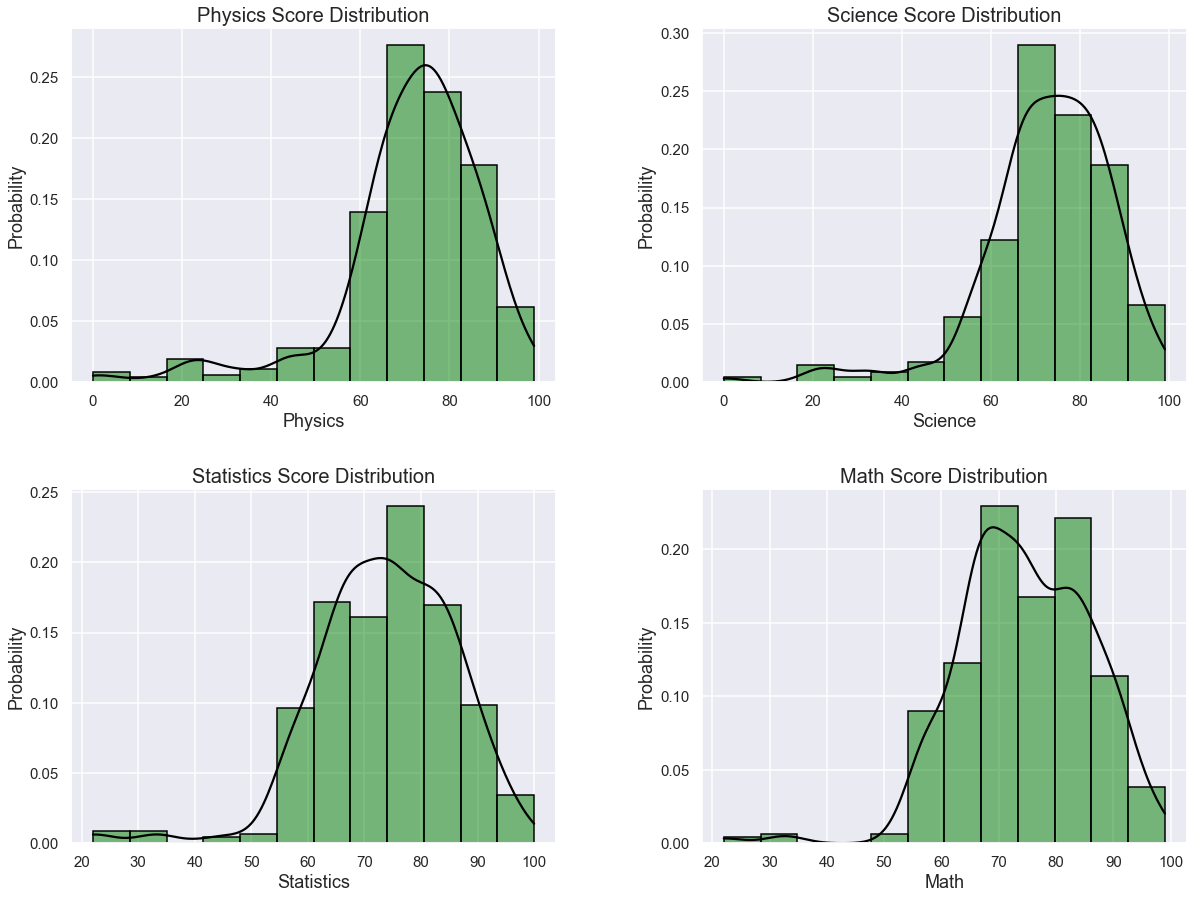

In [131]:
fig, ax=plt.subplots(2,2 ,figsize=(20,15))
sns.histplot(data=data, x='Physics', kde=True, stat='probability', bins=12, color='green', edgecolor='black', ax=ax[0,0])
ax[0,0].set_title("Physics Score Distribution", size=20)
ax[0,0].tick_params(labelsize=15)
ax[0,0].lines[0].set_color('black')
sns.histplot(data=data, x='Science', kde=True, stat='probability', bins=12, color='green', edgecolor='black', ax=ax[0,1])
ax[0,1].set_title("Science Score Distribution", size=20)
ax[0,1].tick_params(labelsize=15)
ax[0,1].lines[0].set_color('black')
sns.histplot(data=data, x='Statistics', kde=True, stat='probability', bins=12, color='green', edgecolor='black', ax=ax[1,0])
ax[1,0].set_title("Statistics Score Distribution", size=20)
ax[1,0].tick_params(labelsize=15)
ax[1,0].lines[0].set_color('black')
sns.histplot(data=data, x='Math', kde=True, stat='probability', bins=12, color='green', edgecolor='black', ax=ax[1,1])
ax[1,1].set_title("Math Score Distribution", size=20)
ax[1,1].tick_params(labelsize=15)
ax[1,1].lines[0].set_color('black')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.close(0)
plt.show()
#fig.savefig('Score_Dist.png', transparent=True)

### Skewness and Kurtosis

In [46]:
data.skew(axis=0)

Physics      -1.664994
Science      -1.443609
Statistics   -0.849626
Math         -0.561298
dtype: float64

In [47]:
data.kurt(axis=0)

Physics       4.224896
Science       4.173907
Statistics    2.238504
Math          1.648008
dtype: float64

### Scatter Plot and Correlation

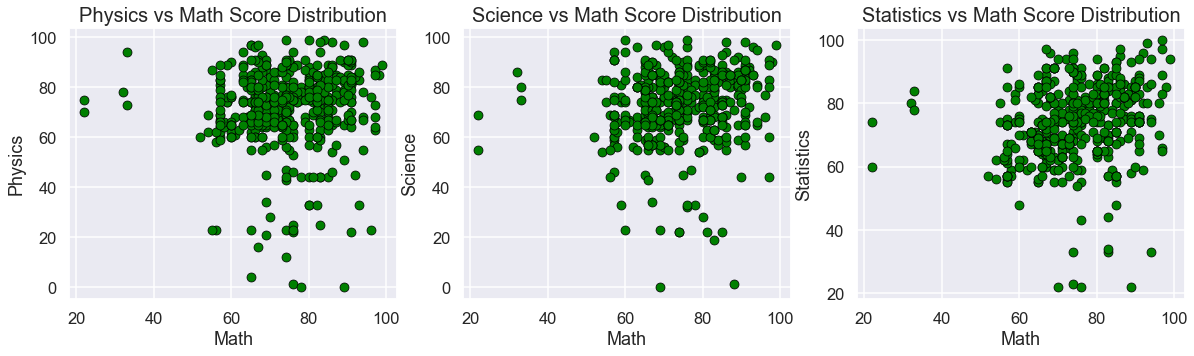

In [136]:
fig, ax=plt.subplots(1,3 ,figsize=(20,5))
sns.scatterplot(data=data, x='Math' , y='Physics', color='green', edgecolor='black', ax=ax[0])
ax[0].set_title("Physics vs Math Score Distribution", size=20)
sns.scatterplot(data=data, x='Math' , y='Science', color='green', edgecolor='black', ax=ax[1])
ax[1].set_title("Science vs Math Score Distribution", size=20)
sns.scatterplot(data=data, x='Math' , y='Statistics', color='green', edgecolor='black', ax=ax[2])
ax[2].set_title("Statistics vs Math Score Distribution", size=20)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.close(0)
plt.show()
#fig.savefig('Scatplot_dist.png', transparent=True)

In [142]:
corr = round(data.corr(method='pearson'), 3)
corr

,Physics,Science,Statistics,Math
Physics,1.000,0.088,0.075,0.053
Science,0.088,1.000,0.163,0.154
Statistics,0.075,0.163,1.000,0.227
Math,0.053,0.154,0.227,1.000


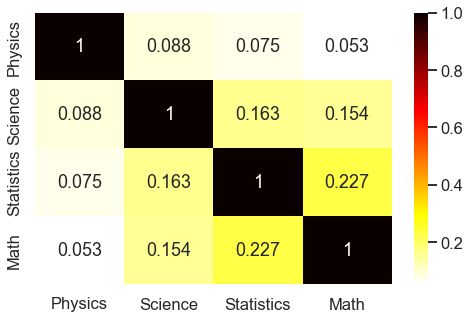

In [168]:
# plot correlation among columns
fig = plt.figure(figsize=(8, 5))
ax = sns.heatmap(corr, cmap='hot_r', annot=True, fmt='g')
#fig.savefig('Correlation.png', transparent=True)

## Data Preparation and Feature Engineering

### Define Upper Class and Lower Class Boundaries

In [189]:
upper_limit_py = data['Physics'].mean() + 3*data['Physics'].std()
lower_limit_py = data['Physics'].mean() - 3*data['Physics'].std()
upper_limit_sc = data['Science'].mean() + 3*data['Science'].std()
lower_limit_sc = data['Science'].mean() - 3*data['Science'].std()
upper_limit_st = data['Statistics'].mean() + 3*data['Statistics'].std()
lower_limit_st = data['Statistics'].mean() - 3*data['Statistics'].std()
upper_limit_mt = data['Math'].mean() + 3*data['Math'].std()
lower_limit_mt = data['Math'].mean() - 3*data['Math'].std()

print("The boundaries for the outliers are as follows:\n")
print("Upper boundary Physics: ",np.round(upper_limit_py, 2))
print("Lower boundary Physics: ",np.round(lower_limit_py, 2))
print('\n')
print("Upper boundary Science: ",np.round(upper_limit_sc, 2))
print("Lower boundary Science: ",np.round(lower_limit_sc, 2))
print('\n')
print("Upper boundary Statistics: ",np.round(upper_limit_st, 2))
print("Lower boundary Statistics: ",np.round(lower_limit_st, 2))
print('\n')
print("Upper boundary Math: ",np.round(upper_limit_mt, 2))
print("Lower boundary Math: ",np.round(lower_limit_mt, 2))

The boundaries for the outliers are as follows:

Upper boundary Physics:  119.84
Lower boundary Physics:  23.64


Upper boundary Science:  115.62
Lower boundary Science:  30.0


Upper boundary Statistics:  110.22
Lower boundary Statistics:  37.14


Upper boundary Math:  108.81
Lower boundary Math:  40.27


### Removing Outlier

In [190]:
upper_py = np.where(data['Physics'] > upper_limit_py)
lower_py = np.where(data['Physics'] < lower_limit_py)
data.drop(upper_py[0], inplace = True)
data.drop(lower_py[0], inplace = True)
data = data.reset_index(drop=True)

upper_sc = np.where(data['Science'] > upper_limit_sc)
lower_sc = np.where(data['Science'] < lower_limit_sc)
data.drop(upper_sc[0], inplace = True)
data.drop(lower_sc[0], inplace = True)
data = data.reset_index(drop=True)

upper_st = np.where(data['Statistics'] > upper_limit_st)
lower_st = np.where(data['Statistics'] < lower_limit_st)
data.drop(upper_st[0], inplace = True)
data.drop(lower_st[0], inplace = True)
data = data.reset_index(drop=True)

upper_mt = np.where(data['Math'] > upper_limit_mt)
lower_mt = np.where(data['Math'] < lower_limit_mt)
data.drop(upper_mt[0], inplace = True)
data.drop(lower_mt[0], inplace = True)
data = data.reset_index(drop=True)

In [191]:
print("New Shape: ", data.shape)
data

New Shape:  (430, 4)


,Physics,Science,Statistics,Math
0,64,67,69,68
1,74,74,63,67
2,60,59,55,57
3,84,88,89,91
4,80,88,78,82
...,...,...,...,...
425,75,91,57,73
426,85,74,74,67
427,65,65,83,85
428,76,91,71,82


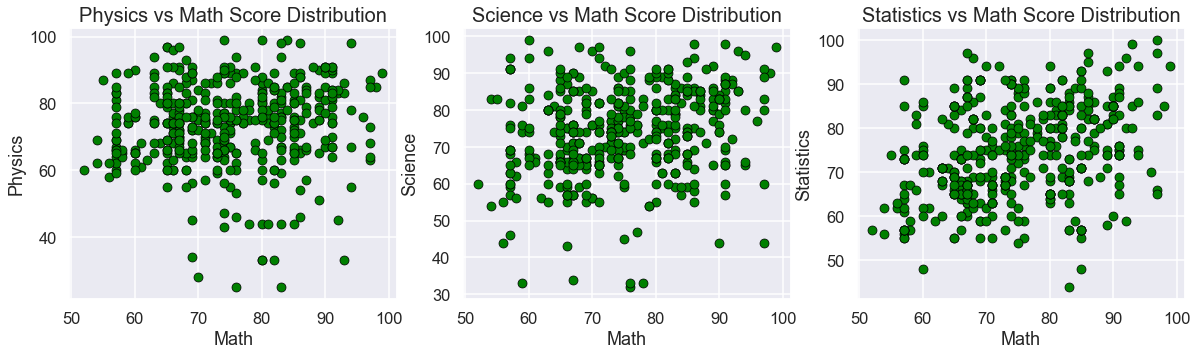

In [192]:
fig, ax=plt.subplots(1,3 ,figsize=(20,5))
sns.scatterplot(data=data, x='Math' , y='Physics', color='green', edgecolor='black', ax=ax[0])
ax[0].set_title("Physics vs Math Score Distribution", size=20)
sns.scatterplot(data=data, x='Math' , y='Science', color='green', edgecolor='black', ax=ax[1])
ax[1].set_title("Science vs Math Score Distribution", size=20)
sns.scatterplot(data=data, x='Math' , y='Statistics', color='green', edgecolor='black', ax=ax[2])
ax[2].set_title("Statistics vs Math Score Distribution", size=20)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.close(0)
plt.show()
#fig.savefig('Scatplot_drop.png', transparent=True)

### Splitting train and validation sets

In [193]:
x = data.iloc[:data.shape[0], :-1]
y = data['Math']

In [205]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 100)

## Creating Model

### Tuning Hyper Parameters

In [250]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [251]:
RF = RandomForestRegressor()
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
RF_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

Best Parameters

In [253]:
RF_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

## Training Model

In [259]:
RF = RandomForestRegressor(n_estimators=200, min_samples_split=2,
                           min_samples_leaf=2, max_features='sqrt',
                           max_depth=80, bootstrap=True, n_jobs=-1
                           )
RF.fit(x_train, y_train)

y_train_pred_RF = RF.predict(x_train)
y_val_pred_RF = RF.predict(x_val)

r2_score_RF_train = round(r2_score(y_train, y_train_pred_RF), 4)
r2_score_RF_val = round(r2_score(y_val, y_val_pred_RF), 4)
mape_RF_train = 100 * mean_absolute_percentage_error(y_train, y_train_pred_RF)
mape_RF_val = 100 * mean_absolute_percentage_error(y_val, y_val_pred_RF)
accuracy_RF_train = 100 - mape_RF_train
accuracy_RF_val = 100 - mape_RF_val

print('R2_score (train): ', r2_score_RF_train)
print('R2_score (test): ', r2_score_RF_val)
print("MAPE (train): {:0.2f}%.".format(mape_RF_train))
print("Accuracy (train): {:0.2f}%.".format(accuracy_RF_train))
print("MAPE (test): {:0.2f}%.".format(mape_RF_val))
print("Accuracy (test): {:0.2f}%.".format(accuracy_RF_val))

R2_score (train):  0.6134
R2_score (test):  0.2013
MAPE (train): 7.14%.
Accuracy (train): 92.86%.
MAPE (test): 10.34%.
Accuracy (test): 89.66%.


## Predicting

### Comparing Actual and Prediction

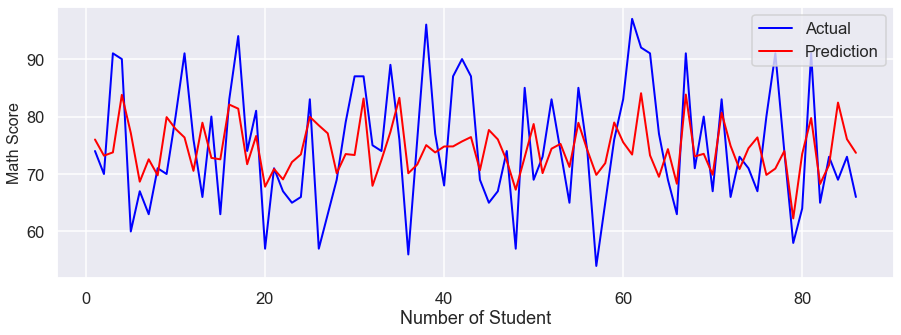

In [267]:
fig = plt.figure(figsize=[15,5])

c = [i for i in range(1,87,1)]
d = [i for i in range(1,87,1)]

plt.plot(c, y_val, color="blue", linewidth=2, linestyle="-", label="Actual")
plt.plot(d, y_val_pred_RF, color="red",  linewidth=2, linestyle="-", label="Prediction")
plt.xlabel('Number of Student', fontsize=18) 
plt.ylabel('Math Score', fontsize=16)
plt.legend(loc="upper right")
plt.show()
#fig.savefig('Prediction.png', transparent=True)

In [291]:
y_val = y_val.ravel()
versus = pd.DataFrame({"Actual":y_val, "Predicted":y_val_pred_RF, 'Different':y_val-y_val_pred_RF})
versus.head(10).style.hide_index().highlight_max(color = 'black')

Actual,Predicted,Different
74,76.002072,-2.002072
70,73.196305,-3.196305
91,73.764617,17.235383
90,83.778531,6.221469
60,77.136287,-17.136287
67,68.664527,-1.664527
63,72.563416,-9.563416
71,69.769148,1.230852
70,79.899848,-9.899848
80,77.845656,2.154344


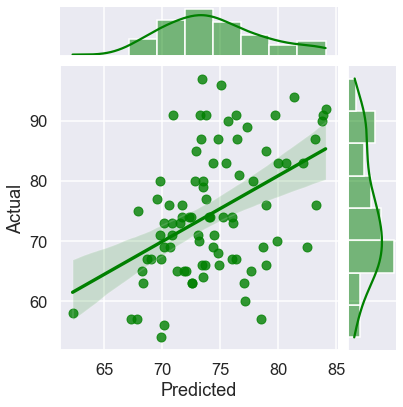

In [299]:
fig = sns.jointplot(versus['Predicted'], versus['Actual'],
                    kind='reg', color='green')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#fig.savefig('Act_vs_Pred.png', transparent=True)

## Feature Importance and SHAP Summary

In [333]:
labels=['Physics', 'Science', 'Statistics']
 
RF.fit(x_train, y_train)    
explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(x_train)

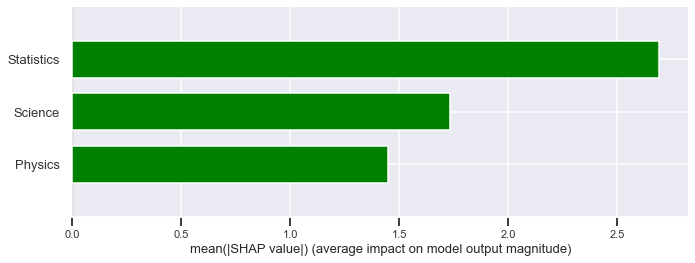

In [350]:
shap.summary_plot(shap_values,
                  x_train,
                  feature_names=labels,
                  plot_type="bar",
                  plot_size=(10,4),
                  color='green',
                  show=False)
plt.savefig('SHAP_Bar.png', transparent=True)

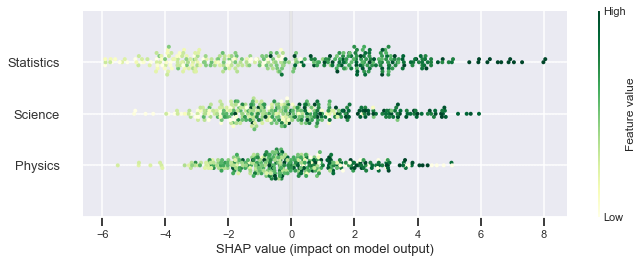

In [351]:
shap.summary_plot(shap_values,
                  x_train,
                  feature_names=labels,
                  plot_size=(10,4),
                  cmap='YlGn',
                  show=False)
plt.savefig('SHAP_Plot.png', transparent=True)